## Notes!
I started this using Kaggle's starter notebook. I made minor tweaks to the code, but it is largely pre-built. If you're interested in seeing how some of the notebook based visualization tools work, it's a good place to start. 
If you're just here to see what I made, skip ahead to the headline "Cross-Validation, Hyperparameters and Modeling."


1. ## Introduction
1. Greetings from the Kaggle bot! This is an automatically-generated kernel with starter code demonstrating how to read in the data and begin exploring. Click the blue "Edit Notebook" or "Fork Notebook" button at the top of this kernel to begin editing.

## Exploratory Analysis
To begin this exploratory analysis, first use `matplotlib` to import libraries and define functions for plotting the data. Depending on the data, not all plots will be made. (Hey, I'm just a kerneling bot, not a Kaggle Competitions Grandmaster!)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


There is 1 csv file in the current version of the dataset:


In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


The next hidden code cells define functions for plotting data. Click on the "Code" button in the published kernel to reveal the hidden code.

In [ ]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


Now you're ready to read in the data and use the plotting functions to visualize the data.

### Let's check 1st file: /kaggle/input/creditcard.csv

In [ ]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# creditcard.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/kaggle/input/creditcard.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'creditcard.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

Let's take a quick look at what the data looks like:

In [ ]:
df1.head(5)

Distribution graphs (histogram/bar graph) of sampled columns:

In [ ]:
plotPerColumnDistribution(df1, 10, 5)

Correlation matrix:

In [ ]:
plotCorrelationMatrix(df1, 8)


Scatter and density plots:

In [ ]:
plotScatterMatrix(df1, 27, 10)  # signature(data, plotSize, textSize) #uses 10 columns at most, this is a computation intensive plot

## Conclusion
This concludes your starter analysis! To go forward from here, click the blue "Edit Notebook" button at the top of the kernel. This will create a copy of the code and environment for you to edit. Delete, modify, and add code as you please. Happy Kaggling!

## Cross-Validation, Hyperparameters and Modeling

I put this together as a learning exercise for myself, but I hope that others can benefit from the examples that I've strung together. 

If anyone finds it useful, please let me know.  



In [ ]:
from sklearn.metrics import accuracy_score, auc, balanced_accuracy_score, confusion_matrix, f1_score, precision_score, average_precision_score, roc_auc_score,  recall_score,  precision_recall_curve #some scoring functions

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest, RandomForestClassifier # Some classifiers
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split #Cross validation tools, and a train/test split utility
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV #Hyper parameter search tools
from hyperopt import hp, tpe, STATUS_OK, fmin, Trials #Hyperparameter search using a loss function 


In [ ]:
# creditcard.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df = pd.read_csv('/kaggle/input/creditcard.csv', delimiter=',')
df.dataframeName = 'creditcard.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

In [ ]:
X = df.iloc[:, 1:30]
y = df.iloc[:, 30:31]
X.head(), y.head()

In [ ]:
# Let's split our dataset and see what it looks like:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.25)
training_fraud = sum(y_train.values)
training_fraud_pct = sum(y_train.values)/len(y_train.values)*100
test_fraud = sum(y_test.values)
test_fraud_pct = sum(y_test.values)/len(y_test.values)*100
print("X train: {}\nX test:  {}\ny_train: {}\ny test:  {} \nFraud in train set: {},   {:2f}%\nFraud in test set:  {},  {:2f}%\n".format( X_train.shape, 
                                                                                                                      X_test.shape, 
                                                                                                                      y_train.shape, 
                                                                                                                      y_test.shape, 
                                                                                                                      training_fraud[0], training_fraud_pct[0],
                                                                                                                      test_fraud[0], test_fraud_pct[0]))

The stratify=y parameter of train_test_split gives an even ratio of our imbalanced class in each of our splits.  


Let's try RandomForest. What parameters are available?

In [ ]:
RandomForestClassifier()

That's neat, but what do the parameters actually do?

In [ ]:
help(RandomForestClassifier)

Cool. But for now, let's just try and run it with the basic settings.

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train.values.ravel())

Ok. It ran. What next?

Let's see how well it predicts in our testing set. 

In [ ]:
y_pred = clf.predict(X_test) # Using our test set, let's try and make some predictions

In [ ]:
confusion_matrix(y_test, y_pred) # How did we do?  

# TN FN
# FP TP                               

What other metrics are out there?

In [ ]:
def print_scores(y_t, y_p):
    print(f'Accuracy  :{accuracy_score(y_t, y_p):.2f}' )
    print(f'Balanced  :{balanced_accuracy_score(y_t, y_p):.2f}' )
    print(f'F1        :{f1_score(y_t, y_p):.2f}' )
    print(f'Precision :{precision_score(y_t, y_p):.2f}' )
    print(f'Recall    :{recall_score(y_t, y_p):.2f}' )
    print(f'roc auc   :{roc_auc_score(y_t, y_p):.2f}' )
    print(f'pr)auc    :{average_precision_score(y_t, y_p):.2f}' )
print_scores(y_test, y_pred)


are these accurate? Probably. But we can get a better picture of how are model is using our training data by trying cross validation.

In [ ]:
#let's start over...
clf = RandomForestClassifier(n_jobs=-1,n_estimators=10, verbose=1)
# ... but this time, let's fit our model using sklearn.model_selection.cross_val_score
cvs = cross_val_score(clf,X=X_train, y=y_train, scoring='average_precision')


In [ ]:
print(f'Using {len(cvs)} trials:\n {cvs}')
print(f'Average:{np.mean(cvs)}')

This gives us a better sense of how accurate our model by making better use of our training set. 
For now, just realize, cross-validation uses a repeated sampling strategy to get a more accurate score (see also, k-fold). 

Moving on, we can also use cross validation to return multiple scores:



In [ ]:
#let's start over...
clf = RandomForestClassifier(n_jobs=-1, verbose=0) # these settings use multiple cores, and provide more command line feedback
# ... but this time, let's fit our model using sklearn.model_selection.cross_validate
cvs = cross_validate(clf,X=X_train, y=y_train, scoring=['accuracy','average_precision','balanced_accuracy','f1','precision','recall','roc_auc'])


In [ ]:
for k, v in cvs.items():
    print(f'{k.replace("test_",""):23}{v}   Avg:{"":4}{np.mean(v):.2f}' )

So, why might cross validation matter? The metric suggested by the providers of the dataset suggests that average precision be used. 

> Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

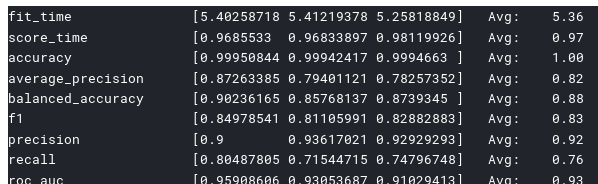

We have an average of .82, but our answers range from .78 to .87,  That seems like fairly wide range. 

Let's try again, but with more folds in our cross validation samples. 

In [ ]:
#let's start over again...
clf = RandomForestClassifier(n_jobs=-1, n_estimators=10, verbose=0) # these settings use multiple cores, and provide more command line feedback
# ... but this time, let's fit our model using sklearn.model_selection.cross_validate
cvs = cross_validate(clf,X=X_train, y=y_train.values.ravel(), cv=10, scoring=['accuracy','average_precision','balanced_accuracy','f1','precision','recall','roc_auc'])


In [ ]:
k_formatter = lambda k: k.replace('test_','')         # formatter for striping out the test prefix from our CV score names
v_formatter = lambda val: str(val)[:6].ljust(6, '0')  # formatter for displaying our values to 4 significant digits. 

for k, v in cvs.items():
    v_print = ', '.join(map(v_formatter, v)) 
    print(f'{k_formatter(k):23} {v_print}     Avg:  {np.mean(v):.4f}    SDev:  {np.std(v):.4f}' )
 

So, cross validation uses samples of our data, and can give better scores without using our test data. The test data is reserved to prevent overfitting. 

How can we use this information to get the best parameters for our model?

One way is using GridSearchCV. Grid search uses each combination of the parameters provided. It's an exhaustive search, and can be time consuming.

The parameter tuning guide for random forests notes that increasing n_estimators and max_features should always improve results, but that it may be computationally intensive with diminishing returns.
It also explains that max_depth and min_samples_split have reasonable defaults, but may be suboptimal. 

> 1.11.2.3. Parameters
>
> The main parameters to adjust when using these methods is n_estimators and max_features. The former is the number of trees in the forest. The larger the better, but also the longer it will take to compute. In addition, note that results will stop getting significantly better beyond a critical number of trees. The latter is the size of the random subsets of features to consider when splitting a node. The lower the greater the reduction of variance, but also the greater the increase in bias. Empirical good default values are max_features=None (always considering all features instead of a random subset) for regression problems, and max_features="sqrt" (using a random subset of size sqrt(n_features)) for classification tasks (where n_features is the number of features in the data). Good results are often achieved when setting max_depth=None in combination with min_samples_split=2 (i.e., when fully developing the trees). Bear in mind though that these values are usually not optimal, and might result in models that consume a lot of RAM. The best parameter values should always be cross-validated. In addition, note that in random forests, bootstrap samples are used by default (bootstrap=True) while the default strategy for extra-trees is to use the whole dataset (bootstrap=False). When using bootstrap sampling the generalization accuracy can be estimated on the left out or out-of-bag samples. This can be enabled by setting oob_score=True.
More here: https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters

GridSearchCV ( and RandomSearchCV ), let you define a set of parameters, and a scoring method, and then run the fit repeatedly, trying to get the best combination of parameters. 

In [ ]:
# let's start over again...
# but this time, our parameter grid will look a bit different. 

param_grid = {'max_depth':[ 5, 15, None], 
              'max_features': [None, 'sqrt'],
              'n_estimators':[100, 500],
              'min_samples_split':[2,3,5]}
clf = RandomForestClassifier(n_jobs=-1, verbose=1,oob_score=True)       # We declare an instance of our classifier
                                                                        # But instead of fitting it, We pass it, 
clf_cv = GridSearchCV(clf, param_grid, scoring="average_precision",     # (and our parameter grid) to a new instance
                      n_jobs=-1, verbose=1)                             # of a grid search object

In [ ]:
# this will take a long time. 3*3*2*2= 36 fits, with 3-fold cross-validation = 108 fits

# clf_cv.fit(X_train, y_train)

RandomSearchCV is a bit different. Instead of testing every combination of parameters, it tests random combinations parameters a preset number of times. 

For more information, SciKit Learn has a [more detailed explanation.](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py)



In [ ]:
# let's start over again...
# but this time, our parameter grid will look a bit different. 
from scipy.stats import randint as sp_rand_int

param_grid = {'max_depth': sp_rand_int(5,30), 
              'max_features': sp_rand_int(5,30),
              'n_estimators':sp_rand_int(100,500),
              'min_samples_split':sp_rand_int(2,5)}
clf = RandomForestClassifier(n_jobs=-1, verbose=1,oob_score=True) 
clf_cv =RandomizedSearchCV(clf, param_grid, scoring="average_precision",     # (and our parameter grid) to a new instance
                      n_jobs=-1, verbose=1, n_iter=10)

In [ ]:
# This will run 10 times with 3-fold validation, for 30 fits. 
clf_cv.fit(X_train, y_train)

In [ ]:
clf_cv.best_
